In [1]:
!nvidia-smi

Fri Jun 19 04:37:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   40C    P0    74W / 250W |     11MiB / 11019MiB |     40%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   37C    P8    25W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


In [3]:
%load_ext autoreload
%autoreload 2

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf
%pylab inline

batch mode...


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


Populating the interactive namespace from numpy and matplotlib


In [4]:
#TF2 compatable painter
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [5]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [6]:
#updated pk for batch mode...
def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    bs = field.shape[0] #batch size

    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(
    tf.signal.fft3d, field_complex, dtype=None, parallel_iterations=None, back_prop=True,
    swap_memory=False, infer_shape=True, name=None
    )


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[bs,-1,])
    imag = tf.reshape(tf.math.imag(pk),[bs,-1,])


    #def bincount func

    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))

    Psum1 = tf.dtypes.cast(tf.map_fn(
    bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
    swap_memory=False, infer_shape=True, name=None
    ),dtype=tf.complex64)*1j

    Psum2 = tf.dtypes.cast(tf.map_fn(
    bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
    swap_memory=False, infer_shape=True, name=None
    ),dtype=tf.complex64)


    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* boxsize.prod() 

    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [7]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 64]
halo_table = halo_table[halo_table['halo_y'] < 64]
halo_table = halo_table[halo_table['halo_z'] < 64]

tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [8]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [9]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [10]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.4,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [11]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=64):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / 64. * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / 64. * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

In [12]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [13]:
#check all variables for batch-ness

rho = sample(tf_halocat, [15.02,11.0,10.02], [0.26,0.22,0.40], [10.0,11.,13.0], [10.31,12.0,13.0], [1.06,1.06,1.06])

Tensor("Pow:0", shape=(3,), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(3, 19457, 3) (3, 19457)
(3, 778280, 3) (3, 778280)


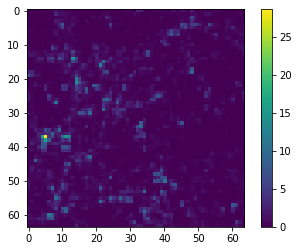

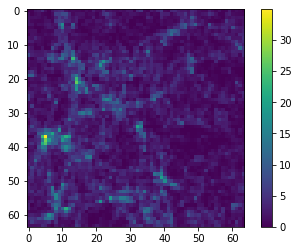

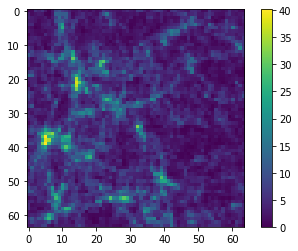

In [14]:

#check that something different is happening :P

imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

imshow(np.array(rho[2]).sum(axis=0))
colorbar()
show()


In [15]:
k1, pkr1 = pk(rho,
         shape=rho[0].shape, 
         boxsize= np.array([64,64,64]), # WARNING: That's not the right size
         kmin=0.1,dk=.05)

<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


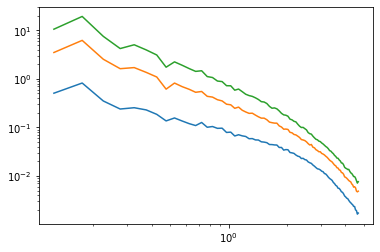

In [16]:
for pks in pkr1:
    loglog(k1,pks)

In [17]:
#fiducial model
rho = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 1.06)
k2, pkr2 = pk(rho,
         shape=rho[0].shape, 
         boxsize= np.array([64,64,64]), # WARNING: That's not the right size
         kmin=0.1,dk=.05)

Tensor("Pow:0", shape=(), dtype=float32)
(1, 19457, 3) (1, 19457)
(1, 778280, 3) (1, 778280)


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


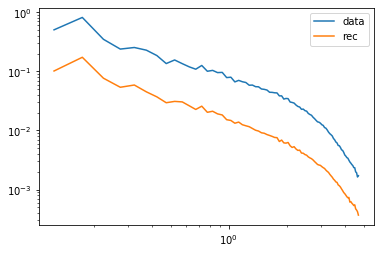

In [18]:
loglog(k1,pkr1[0], label='data')
loglog(k2,pkr2[0], label='rec')
legend()

In [19]:
# Let's just compute a diagonal cov (takes a while...)
@tf.function
def get_pk(halocat):
    k2, pkr = pk(sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 1.06 ),
         shape=rho[0].shape, 
         boxsize= np.array([64,64,64]), # WARNING: That's not the right size
         kmin=0.1,dk=.05)
    return pkr

samps = [get_pk(halocat) for i in range(200)]
samps = np.stack(samps, axis=0)
diag_std = samps.std(axis=0)

In [20]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)
logM0 = tf.Variable(10.38)
logM1 = tf.Variable(13.01)
alpha = tf.Variable(1.6)

In [21]:
learning_rate=0.0000002

@tf.function
def opt_step(tf_halocat, pkref):
    with tf.GradientTape() as tape:
        _, pkr = pk(sample(tf_halocat, logM, sig_logM, 11.38, logM1, alpha),
             shape=rho[0].shape, 
             boxsize= np.array([64,64,64]), # WARNING: That's not the right size
             kmin=0.1,dk=.05)
        loss = tf.reduce_sum((pkr - pkref)**2/diag_std**2)

    grads = tape.gradient(loss, [logM, sig_logM, logM1, alpha])
    alpha.assign_sub(learning_rate*grads[3])
    logM1.assign_sub(learning_rate*grads[2]);
    logM.assign_sub(learning_rate*grads[0]);
    sig_logM.assign_sub(learning_rate*grads[1]);
    return loss

In [ ]:
for i in range(1000):
    loss = opt_step(tf_halocat, pkr2)
#    print('loss', loss.numpy())

Tensor("Pow:0", shape=(), dtype=float32)


In [ ]:
#true values: 12.02, 0.26,  13.31, 1.06 
#starting values: 12.5,0.5,10.38,13.01,1.6
logM, sig_logM, logM0, logM1, alpha

In [ ]:
#much closer to true values than starting values! :D

<ipython-input-22-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


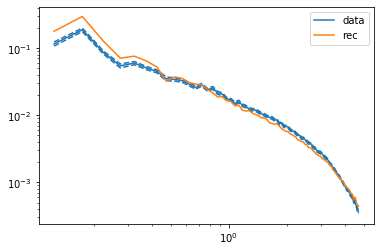

In [61]:
_, pkr = pk(sample(tf_halocat, logM, sig_logM, logM0, logM1, alpha),
     shape=rho[0].shape, 
     boxsize= np.array([64,64,64]), # WARNING: That's not the right size
     kmin=0.1,dk=.05)

loglog(k1,pkr2[0], label='data')
loglog(k1,pkr2[0]-diag_std[0], '--', color='C0')
loglog(k1,pkr2[0]+diag_std[0], '--', color='C0')

loglog(k2,pkr[0], label='rec')
legend()

In [65]:
#quick example showing large sample... use this for covariance estimation? might be just as slow with the map_fn

k, pko = pk(sample(tf_halocat, tf.Variable(np.ones(10)*logM,dtype=float32), tf.Variable(sig_logM,dtype=float32), tf.Variable(logM0,dtype=float32), tf.Variable(logM1,dtype=float32), tf.Variable(alpha,dtype=float32)),shape=rho[0].shape, 
     boxsize= np.array([64,64,64]), # WARNING: That's not the right size
     kmin=0.1,dk=.05)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable